In [1]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from snes import SNES
import os
import cv2
import matplotlib.pyplot as plt
from dataSet import dataSet

Using TensorFlow backend.


In [2]:
#randomforest classifier
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred
#prediction 
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 31

# use just a small sample of the train set to test
SAMPLE_SIZE = 400
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 20
# how many times we will loop over ask()/tell()
GENERATIONS = 20

In [3]:
#Loading the data from path-
# This part adopted from LYU CHAOFAN_Github(permission was obtained)https://github.com/C-002/CE888_Assignment/blob/master/LoadImages.ipynb
Amazon_path = './Original_images/amazon/images'
dslr_path   = './Original_images/dslr/images'
webcam_path = './Original_images/webcam/images'
paths = [Amazon_path, dslr_path, webcam_path]
files = os.listdir(Amazon_path)
labels = {}
count  = 0
for key in files:
    a = {key : count}
    labels.update(a)
    count += 1
images_path = []
dslr   = dataSet()
webcam = dataSet()
#loading DSLR data
for dirname in files:
    images_name = os.listdir(dslr_path + '/' + dirname)
    for name in images_name:
        Image_Path = dslr_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        dslr.upData(image_data, labels[dirname], labels)
dslr.sHape()
#loading webcam data
for dirname in files:
    images_name = os.listdir(webcam_path + '/' + dirname)
    for name in images_name:
        Image_Path = webcam_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        webcam.upData(image_data, labels[dirname], labels)
webcam.sHape()

#label classifier data
x_train = webcam.data
y_train = webcam.label
x_test  = dslr.data
y_test  = dslr.label
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)
#data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#domain classifier data
x_domain=np.concatenate((x_train,x_test), axis =0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis=0)
print("For label classifier")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("For domain classifier")
print('x_domain shape:', x_domain.shape)
print(y_domain.shape[0], 'domain samples')

For label classifier
x_train shape: (795, 28, 28, 3)
x_test shape: (498, 28, 28, 3)
795 train samples
498 test samples
For domain classifier
x_domain shape: (1293, 28, 28, 3)
1293 domain samples


In [4]:
#the neural network model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(31, activation='relu'))
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [5]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print('x_test shape:',y_test.shape)
print('x_pred shape:',y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)

Total number of weights to evolve is: (305119,)


x_test shape: (498,)
x_pred shape: (498,)
Non-trained NN Test accuracy: 0.11044176706827309


In [6]:
#evolutionary process with SNES
snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []
    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])

        # calculate the predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        y_pred2 = predict_classifier(model, clf, x_domain[subsample_indices_valid])
        score2 = accuracy_score(y_domain[subsample_indices_valid], y_pred)
                    
        # append to array of values that are to be returned
        total=score+score2
        told.append(total)

    t = snes.tell(asked, told)
    log.append(t)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
nnw.set_weights(snes.center)

clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy on target:', test_accuracy)


Step 1.0 : 0.7356608478802992 best: 0.7356608478802992 20
It took 23.993336598565765 seconds to complete generation 1


Step 2.0 : 0.7206982543640899 best: 0.7356608478802992 20
It took 26.12942203622856 seconds to complete generation 2


Step 3.0 : 0.7406483790523691 best: 0.7406483790523691 20
It took 26.97324625106534 seconds to complete generation 3


Step 4.0 : 0.6957605985037406 best: 0.7406483790523691 20
It took 25.72596766009424 seconds to complete generation 4


Step 5.0 : 0.71571072319202 best: 0.7406483790523691 20
It took 25.922113980589856 seconds to complete generation 5


Step 6.0 : 0.7481296758104738 best: 0.7481296758104738 20
It took 24.764601777400713 seconds to complete generation 6


Step 7.0 : 0.7007481296758105 best: 0.7481296758104738 20
It took 24.696914849014746 seconds to complete generation 7


Step 8.0 : 0.745635910224439 best: 0.7481296758104738 20
It took 24.69818744338295 seconds to complete generation 8


Step 9.0 : 0.7381546134663343 best: 0.7481296758104738 20
It took 24.70540515857357 seconds to complete generation 9


Step 10.0 : 0.7231920199501247 best: 0.7481296758104738 20
It took 24.679606648803087 seconds to complete generation 10


Step 11.0 : 0.7107231920199502 best: 0.7481296758104738 20
It took 24.7332484937088 seconds to complete generation 11


Step 12.0 : 0.7630922693266833 best: 0.7630922693266833 20
It took 24.71384504391665 seconds to complete generation 12


Step 13.0 : 0.6957605985037406 best: 0.7630922693266833 20
It took 24.82291050689031 seconds to complete generation 13


Step 14.0 : 0.7581047381546135 best: 0.7630922693266833 20
It took 26.9770746126768 seconds to complete generation 14


Step 15.0 : 0.7605985037406483 best: 0.7630922693266833 20
It took 26.667676208832404 seconds to complete generation 15


Step 16.0 : 0.7206982543640897 best: 0.7630922693266833 20
It took 24.850350800916374 seconds to complete generation 16


Step 17.0 : 0.7182044887780549 best: 0.7630922693266833 20
It took 24.659916168859752 seconds to complete generation 17


Step 18.0 : 0.7331670822942643 best: 0.7630922693266833 20
It took 24.94692022642232 seconds to complete generation 18


Step 19.0 : 0.740648379052369 best: 0.7630922693266833 20
It took 24.671486586982326 seconds to complete generation 19


Step 20.0 : 0.713216957605985 best: 0.7630922693266833 20
It took 24.696519918094168 seconds to complete generation 20


(498,) (498,)
Test accuracy on target: 0.09236947791164658


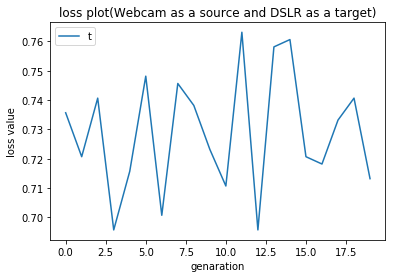

In [7]:
#Plot the loss for each generation
plt.plot(log)
plt.title('loss plot(Webcam as a source and DSLR as a target)')
plt.xlabel('genaration')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.savefig('Plot_webcam_dslr.png')
plt.show()